# WaterShed Challenge

## 1. Libraries and Data

In [1]:
!pip install folium
!pip install pandas --upgrade
!pip install statsmodels

Requirement already up-to-date: pandas in c:\python39\lib\site-packages (1.4.3)


In [2]:
import pandas as pd
import datetime as dt
import folium
from folium.plugins import MarkerCluster
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [3]:
df_flux = pd.read_csv('flux.csv')

## 2. EDA

In [4]:
df_flux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4180480 entries, 0 to 4180479
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   date        object 
 1   basin_id    int64  
 2   flux        float64
 3   precip      float64
 4   temp_max    float64
 5   gauge_name  object 
 6   lat         float64
 7   lon         float64
 8   mean_elev   float64
 9   area_km2    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 318.9+ MB


In [5]:
df_flux['date'] = pd.to_datetime(df_flux['date'])
df_flux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4180480 entries, 0 to 4180479
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   basin_id    int64         
 2   flux        float64       
 3   precip      float64       
 4   temp_max    float64       
 5   gauge_name  object        
 6   lat         float64       
 7   lon         float64       
 8   mean_elev   float64       
 9   area_km2    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 318.9+ MB


In [6]:
df_flux.head()

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
0,1980-01-01,1001001,0.579,0.0,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
1,1980-01-02,1001001,0.543,0.0,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
2,1980-01-03,1001001,0.482,0.0,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
3,1980-01-04,1001001,0.459,0.0,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
4,1980-01-05,1001001,0.436,0.0,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859


In [7]:
df_flux['gauge_name'].value_counts()

Rio Aconcagua En Chacabuquito                   14670
Rio Cruces En Rucaco                            14649
Rio Choapa En Cuncumen                          14639
Rio Elqui En Algarrobal                         14634
Rio Cautin En Cajon                             14603
                                                ...  
Estero Chimbarongo En Santa Cruz                  328
Rio Chillan En Longitudinal                       302
Rio Pama Entrada Embalse Cogoti                   195
Estero Las Vegas Aguas Abajo Canal Las Vegas      195
Rio Blanco En Chaiten                             175
Name: gauge_name, Length: 503, dtype: int64

In [8]:
df_flux['basin_id'].value_counts()

5410002     14670
10134001    14649
4703002     14639
4320001     14634
9129002     14603
            ...  
6034001       328
8117001       302
4534001       195
5423002       195
10683002      175
Name: basin_id, Length: 503, dtype: int64

### 2.1 Locate stations on map

In [9]:
station_location = df_flux[['lat', 'lon']]
station_location.drop_duplicates(inplace=True)

C:\Users\EXMACH~1\AppData\Local\Temp/ipykernel_10540/570081029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_location.drop_duplicates(inplace=True)


In [10]:
# Locations lists
station_location_list = station_location.values.tolist()
station_location_cg = df_flux[['lat', 'lon']].mean().tolist()
# Start map
map1 = folium.Map(location=station_location_cg, 
                  tiles='CartoDB positron', 
                  zoom_start=4)
marker_cluster = folium.plugins.MarkerCluster().add_to(map1)
# Locate points
for point in range(0, len(station_location_list)):
    folium.Marker(station_location_list[point], 
                  popup='Name: '+df_flux['gauge_name'][point],
                  icon=folium.Icon(icon_color='white', 
                                   icon='male', 
                                   angle=0, 
                                   prefix='fa')).add_to(marker_cluster)
map1

We observe that we could group stations based on latitude.

### 2.2 Check for missing data

In [11]:
df_flux[df_flux.isnull().any(axis=1)]

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
60493,2020-05-06,1021001,1.707,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60494,2020-05-07,1021001,1.687,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60495,2020-05-08,1021001,1.698,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60496,2020-05-09,1021001,1.694,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60497,2020-05-10,1021001,1.690,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
...,...,...,...,...,...,...,...,...,...,...
4180475,2020-06-02,12930001,0.375,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617
4180476,2020-06-03,12930001,0.342,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617
4180477,2020-06-04,12930001,0.325,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617
4180478,2020-06-05,12930001,0.311,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617


We have 4.1 million rows and about 0.1% have missing values. Let's check proportion of null values that each of the stations that appeared in last print have.

In [12]:
df_flux[df_flux.isnull().any(axis=1)]['gauge_name'].value_counts()

Rio Maipo En Cabimbao                               37
Estero Yerba Loca Antes Junta San Francisco         37
Rio Itata En Paso Hondo                             37
Rio Biobio En Desembocadura                         34
Rio Lauca En Japu (O En El Limite)                  32
                                                    ..
Rio Huequecura Aguas Arriba De Embalse Angostura    22
Rio Maule En Longitudinal                           15
Rio Tolten En Coipue                                15
Rio Chamiza Ante Junta Rio Chico                    10
Rio Loa Antes Represa Lequena                        2
Name: gauge_name, Length: 174, dtype: int64

In [13]:
stations_check = df_flux[df_flux.isnull().any(axis=1)]['gauge_name'].unique()  # Stations that have null values 
df_flux['has_nan'] = df_flux.isnull().any(axis=1)
df_check_nans = df_flux.groupby(['gauge_name','has_nan']).agg(counts = ('date','count'))
df_check_nans.reset_index(inplace=True)
df_check_nans = df_check_nans[df_check_nans['gauge_name'].isin(stations_check)]
df_check_nans = df_check_nans.pivot(index='gauge_name',columns='has_nan', values='counts').reset_index()
df_check_nans

has_nan,gauge_name,False,True
0,Estero Arrayan En La Montosa,13724,32
1,Estero Bellavista En Tom,3729,32
2,Estero Catemu En Puente Santa Rosa,11573,32
3,Estero Chimbarongo Bajo Embalse Convento Viejo,3957,32
4,Estero Chimbarongo En Puente El Huape,2906,32
...,...,...,...
169,Rio Trancura En Curarrehue,13913,32
170,Rio Tres Brazos Antes Bt. Sendos,12537,32
171,Rio Turbio En Varillar,14128,32
172,Rio Uble En San Fabian N 2,7407,32


<AxesSubplot:>

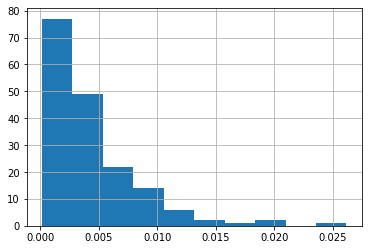

In [14]:
df_check_nans['nan_ratio'] = df_check_nans[True]/(df_check_nans[False]+df_check_nans[True])
df_check_nans['nan_ratio'].hist()

The proportion of null values for each station is very low, so we'll remove those observations.

In [15]:
df_flux = df_flux.dropna()

### 2.3 Check data distribution

### Flux

<AxesSubplot:xlabel='flux', ylabel='Count'>

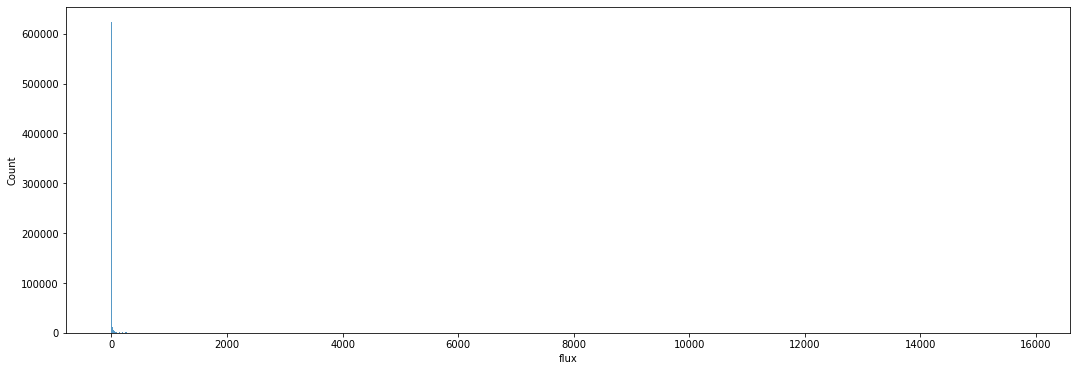

In [16]:
plt.figure(figsize=(18,6))
sns.histplot(df_flux['flux'])
#plt.hist(df_flux['flux'])

The flux variable has a ver ample range, let's use logarithm to see its distribution better

<AxesSubplot:xlabel='flux', ylabel='Count'>

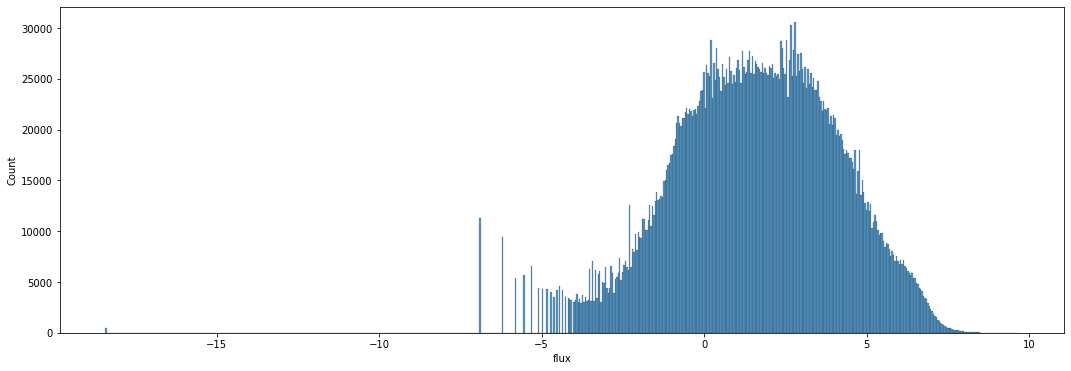

In [17]:
plt.figure(figsize=(18,6))
sns.histplot(np.log(df_flux['flux']+10**-8))
#plt.hist(df_flux['flux'])

There are some very low variables, but they look "nice" otherwise.

### Max Temperature

<AxesSubplot:xlabel='temp_max', ylabel='Count'>

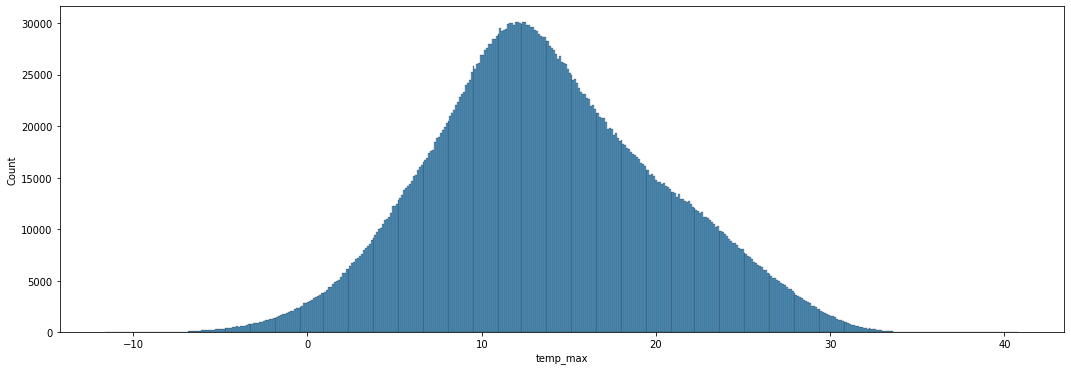

In [18]:
plt.figure(figsize=(18,6))
sns.histplot(df_flux['temp_max'])

### Precipitation

<AxesSubplot:xlabel='precip', ylabel='Count'>

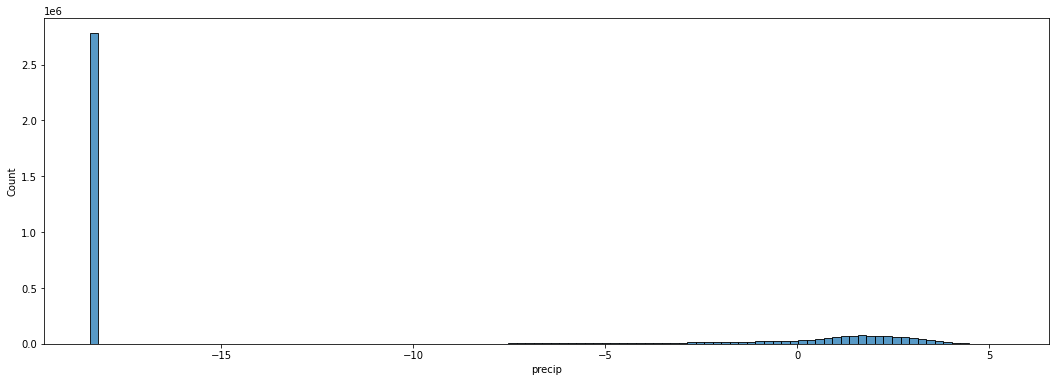

In [19]:
plt.figure(figsize=(18,6))
sns.histplot(np.log(df_flux['precip']+10**-8))
#plt.hist(df_flux['precip'])

### Area km2

c:\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

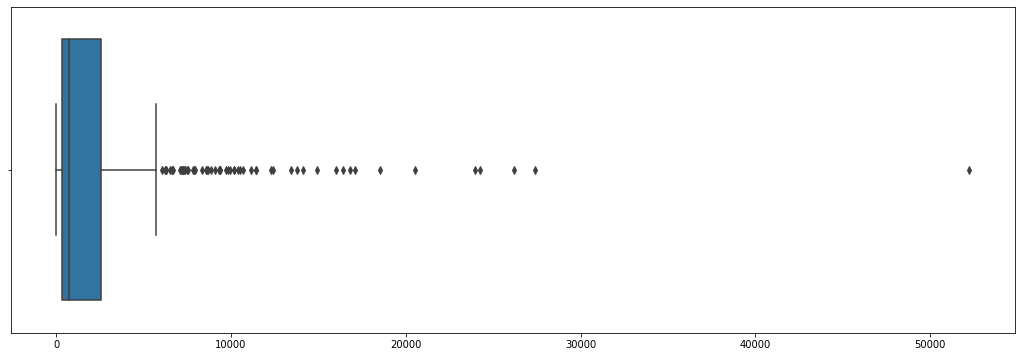

In [20]:
plt.figure(figsize=(18,6))
sns.boxplot(df_flux['area_km2'].unique())

### Latitude

<AxesSubplot:ylabel='Count'>

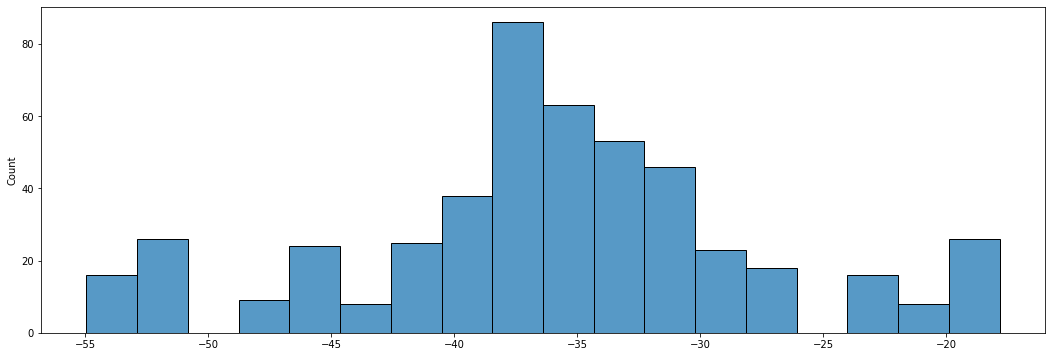

In [21]:
plt.figure(figsize=(18,6))
sns.histplot(df_flux['lat'].unique())

### Mean elevation

<AxesSubplot:ylabel='Count'>

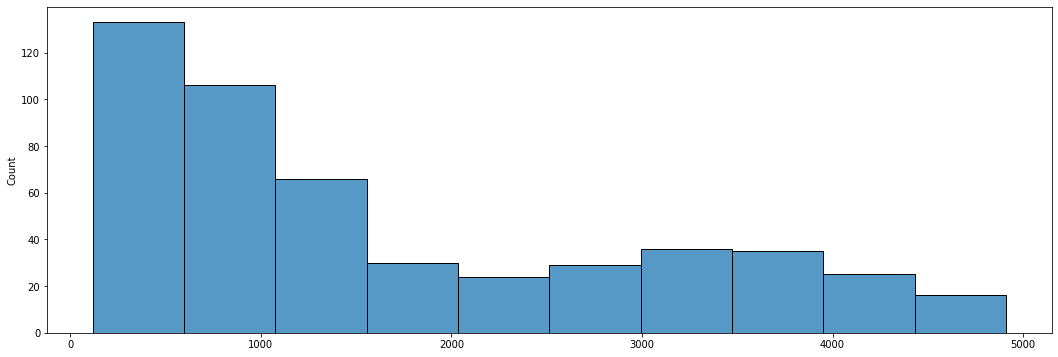

In [22]:
plt.figure(figsize=(18,6))
sns.histplot(df_flux['mean_elev'].unique())

Latitude and elevation are good candidates to be used as clustering variables. For the EDA let's look at how the flux, temperature and precipitation behave for initial clusterings on those 2. We can group stations as follows:

- Latitude:
    - ],-50]
    - ]-50,-47]
    - ]-47,-25]
    - ]-25, ]
- Mean Elevation:
    - ],2200]
    - ]2200,]

In [23]:
# create group variable for latitude, 1 is the northest group and 4 the southest
conditions = [
    (df_flux['lat']<=-50),
    (-50<df_flux['lat']) & (df_flux['lat']<=-47),
    (-47<df_flux['lat']) & (df_flux['lat']<=-25),
    (-25<df_flux['lat']),
    ]
values = ['lat_group_4', 
          'lat_group_3', 
          'lat_group_2',
          'lat_group_1']
df_flux['lat_group'] = np.select(conditions, values)
# create group variable for mean_elev, 1st group has less elevation than 2nd group
conditions = [
    (df_flux['mean_elev']<=2200),
    (2200<df_flux['mean_elev'])
    ]
values = ['mean_elev_group_1', 
          'mean_elev_group_2',]
df_flux['mean_elev_group'] = np.select(conditions, values)

### Comparison over groups

[Text(0.5, 1.0, 'Log flux dist over chosen categorical variables')]

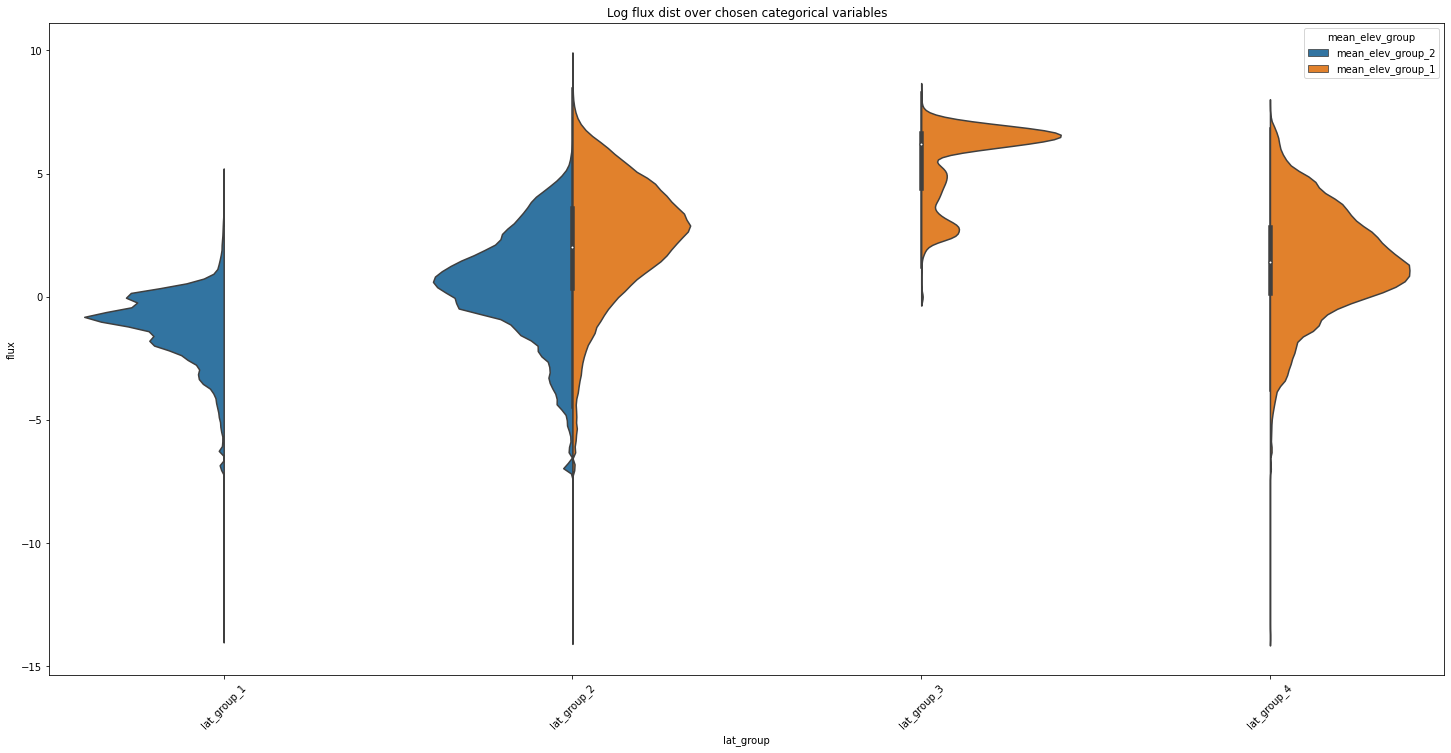

In [24]:
plt.figure(figsize=(25,12))
plt.xticks(rotation=45)
sns.violinplot(x=df_flux['lat_group'], 
            y=np.log(df_flux['flux']+10**-6),
            hue=df_flux['mean_elev_group'],
            split=True,
            dodge=False).set(title='Log flux dist over chosen categorical variables')

For latitude group 3 it would seem that we can further segmentate it to get a cleaner distribution for stations. With this plot we see that flux increases with latitude, and when we fix latitude (in group 2) mean elevation also means an increase in flux

[Text(0.5, 1.0, 'Log precipitation dist over chosen categorical variables')]

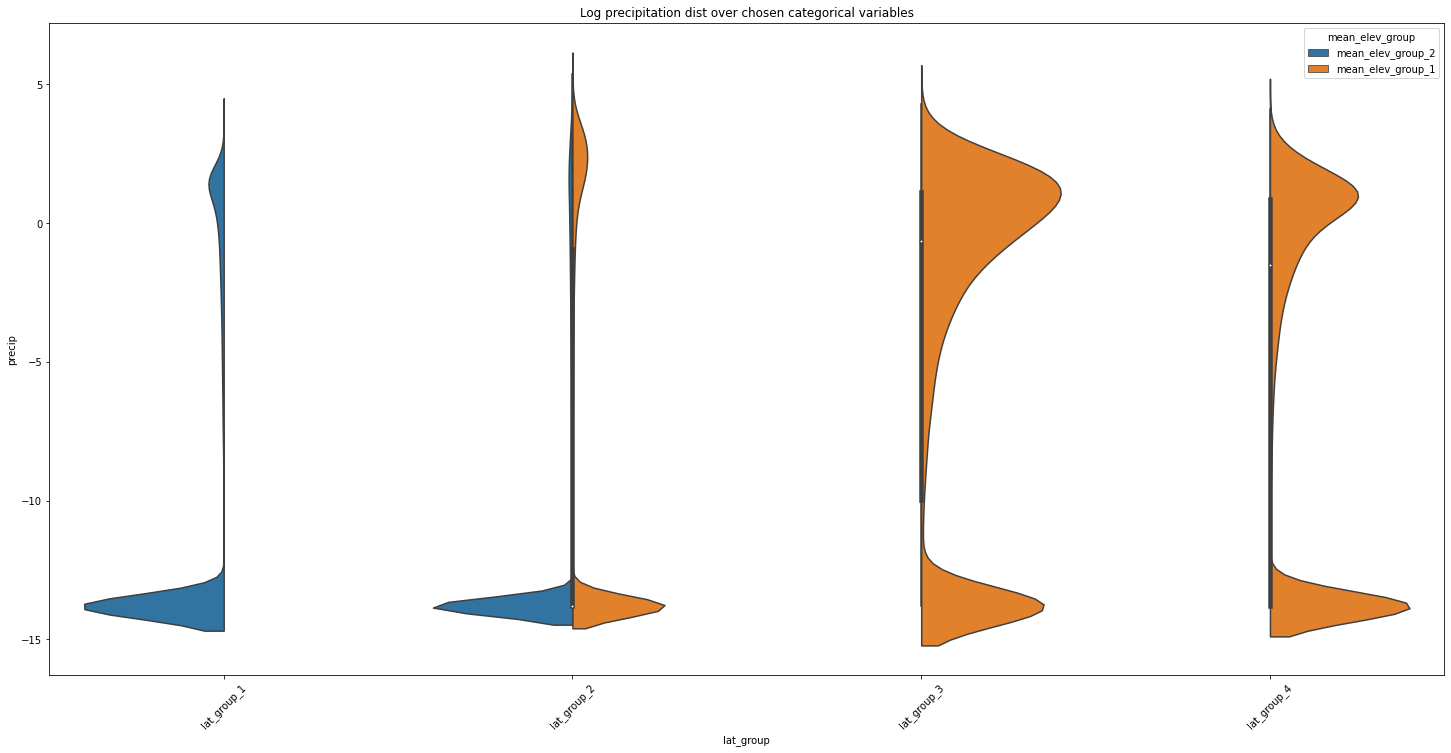

In [25]:
plt.figure(figsize=(25,12))
plt.xticks(rotation=45)
sns.violinplot(x=df_flux['lat_group'], 
            y=np.log(df_flux['precip']+10**-6),
            hue=df_flux['mean_elev_group'],
            split=True,
            dodge=False).set(title='Log precipitation dist over chosen categorical variables')

[Text(0.5, 1.0, 'Max Temp dist over chosen categorical variables')]

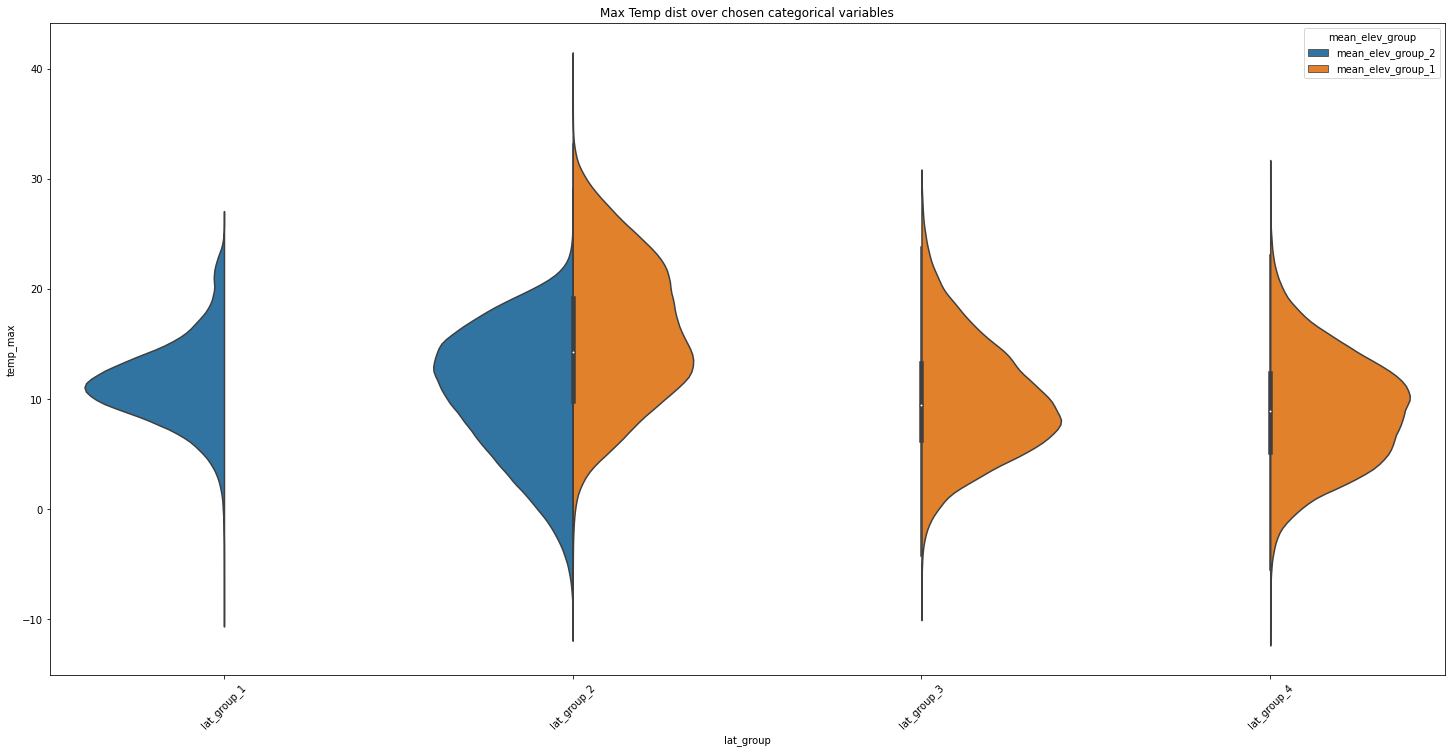

In [26]:
plt.figure(figsize=(25,12))
plt.xticks(rotation=45)
sns.violinplot(x=df_flux['lat_group'], 
            y=df_flux['temp_max'],
            hue=df_flux['mean_elev_group'],
            split=True,
            dodge=False).set(title='Max Temp dist over chosen categorical variables')

The stations that are located in the northern part of Chile all belong to the group of stations higher than 2200 meters above sea level. That would explain why the max temperature of those is not much higher than the stations in the south, which are all below 2200.

In the second group by latitude we observe that elevation has a clear effect on max temperature.

Further analysis should be made by taking a look at what happens for small values of flux and precipitation, which stations only have small values or for which periods. This will allow us to maybe clean the data and remove some faulty observations.

### Analysis of small values of flux and precipitation

We saw in its distributions that there are many zero like values for flux and precipitation, let's see if this happens many times for specific stations

In [27]:
df_flux['flux'].describe()

count    4.175037e+06
mean     5.249398e+01
std      1.674156e+02
min      0.000000e+00
25%      8.690000e-01
50%      5.180000e+00
75%      2.990000e+01
max      1.580500e+04
Name: flux, dtype: float64

In [28]:
#mask_small_values = df_flux['flux']<=1
df_flux_fsmall = df_flux[df_flux['flux']==0]
df_flux_fsmall['gauge_name'].value_counts()

Rio San Jose En Ausipar                        123
Estero Pupio En El Romero                      100
Rio Hollemberg En Desembocadura                 53
Rio Illapel En El Peral                         44
Rio Aconcagua En San Felipe                     35
Rio Blanco En Chaiten                           29
Rio Lluta En Panamericana                       26
Rio Ancoa En El Llepo                           18
Rio Hurtado En Angostura De Pangue               7
Rio Polcura En Cuatro Junta                      7
Rio Illapel En Huintil                           4
Rio Grande En Cuyano                             3
Rio Salado En Sifon Ayquina                      2
Rio Huatacondo En Copaquire                      1
Rio Hurtado En San Agustin                       1
Rio Cipreses En Dasague Laguna La Invernada      1
Name: gauge_name, dtype: int64

Zero values aren't that frequent for flux.

## 3. Plot functions

In [29]:
def plot_one_timeserie(cod_station, variable, min_date, max_date, df = None):
    """Plots a timeseries of given parameters
    
    Args:
        cod_station (int): station code of the station to plot
        variable (str): variable name to plot
        min_date (str): string of the min date to plot (format yyyy-mm-dd)
        max_date (str): string of the max date to plot (format yyyy-mm-dd)
        df (pandas.DataFrame): Optional. 
    """
    if df is None:
        df = df_flux
    min_date = dt.datetime.strptime(min_date, '%Y-%m-%d')
    max_date = dt.datetime.strptime(max_date, '%Y-%m-%d')
    
    mask_1 = df['basin_id']==cod_station
    mask_2 = min_date <= df['date']
    mask_3 = df['date']<=max_date
    df_flux_filtered = df[mask_1 & mask_2 & mask_3]
    
    plt.figure(figsize=(25,6))
    plt.plot(df_flux_filtered['date'], 
             df_flux_filtered[variable])
    #plt.title("Time series of "+variable+" of the station "+cod_station + "between "+str(min_date))

In [30]:
def bound_column(df,var):
    """Bound values of chosen var between 0 and 1"""
    #df = df.copy()
    return (df[var]-df[var].min())/(df[var].max()-df[var].min())    

def plot_three_timeseries(cod_station, min_date, max_date):
    """Plots 3 timeseries of given parameters
    
    Args:
        cod_station (int): station code of the station to plot
        min_date (str): string of the min date to plot (format yyyy-mm-dd)
        max_date (str): string of the max date to plot (format yyyy-mm-dd)
    """
    min_date = dt.datetime.strptime(min_date, '%Y-%m-%d')
    max_date = dt.datetime.strptime(max_date, '%Y-%m-%d')
    
    
    cols_select =['basin_id','date','flux','temp_max','precip']
    df_flux_filtered = df_flux[cols_select]
    
    df_flux_filtered['flux_n'] = bound_column(df_flux_filtered,'flux')
    df_flux_filtered['temp_max_n'] = bound_column(df_flux_filtered,'temp_max')
    df_flux_filtered['precip_n'] = bound_column(df_flux_filtered,'precip')
    
    
    mask_1 = df_flux_filtered['basin_id']==cod_station
    mask_2 = min_date <= df_flux_filtered['date']
    mask_3 = df_flux_filtered['date']<=max_date
    df_flux_filtered = df_flux_filtered[mask_1 & mask_2 & mask_3]
    
    plt.figure(figsize=(25,6))
    plt.plot(df_flux_filtered['date'], df_flux_filtered['flux_n'], label='flux')
    plt.plot(df_flux_filtered['date'], df_flux_filtered['temp_max_n'], label='temp_max')
    plt.plot(df_flux_filtered['date'], df_flux_filtered['precip_n'], label='precip')
    plt.legend()

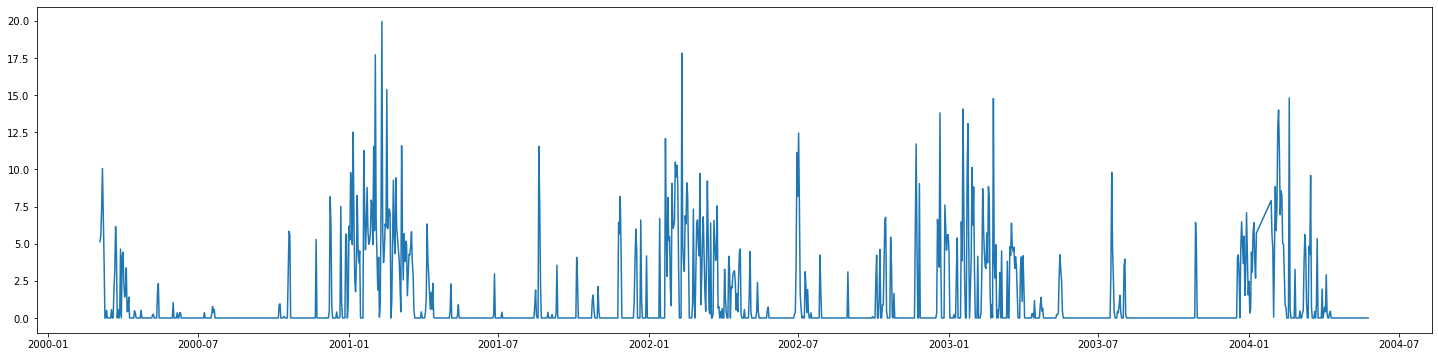

In [31]:
plot_one_timeserie(1001001,'precip','2000-03-04','2020-03-04')

C:\Users\EXMACH~1\AppData\Local\Temp/ipykernel_10540/3210905886.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flux_filtered['flux_n'] = bound_column(df_flux_filtered,'flux')
C:\Users\EXMACH~1\AppData\Local\Temp/ipykernel_10540/3210905886.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flux_filtered['temp_max_n'] = bound_column(df_flux_filtered,'temp_max')
C:\Users\EXMACH~1\AppData\Local\Temp/ipykernel_10540/3210905886.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of

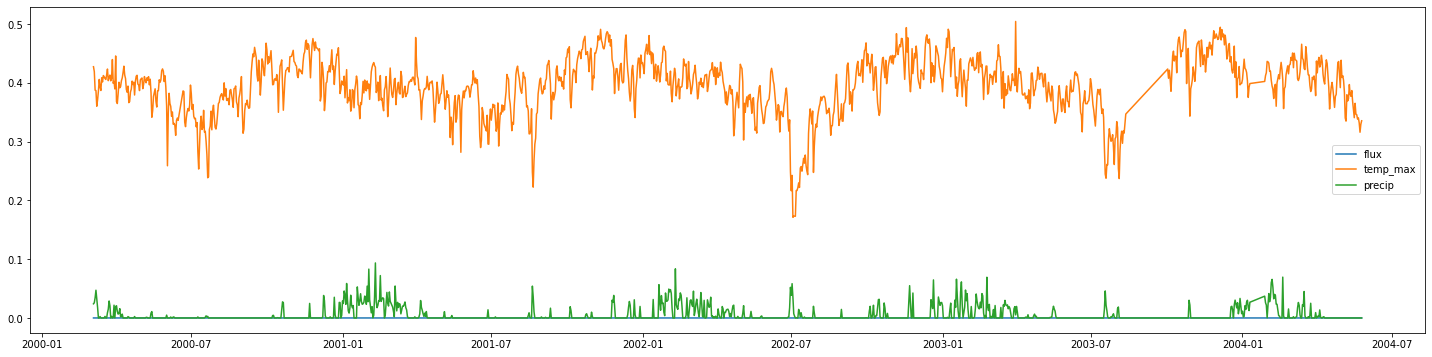

In [32]:
plot_three_timeseries(1001001,'2000-03-04','2021-08-04')

## 4. New three variables

### 4.1 Is the 95 percentile method a good way of capturing extre events?

I don't think the 95 percentile method is the ideal way of capturing the extreme events for the following reasons:
- If the distribution is very concentrated in one point (high kurtosis), values that are not very different from the mode or mean can be classified as extreme and treated the same way as some very extreme values.
- If we are working with time series, like in this challenge, some values are not extreme if we look at data globally, but they will be extreme if compared to those values around it.

I would rather use other methods tipically used to find outliers, such as the interquartile range or the CUSUM method (which is more suitable for time series). For simplicity and time-constraint reasons, I will use interquartile range for each station.

### 4.2 Classifying extreme events

Rather than considering a season, I'll compare the values of each week of the year. This way, an observation can be catalogued as extreme if its value is outside of some range given the historical distribution of the variable on that week.

In [33]:
df_flux['week'] = df_flux['date'].apply(lambda x: x.strftime("%V"))

In [34]:
# We group data by station and week of the year, then, for each group, we calculate the 1st and 3rd quartiles
group_cols = ['gauge_name','week']
agg_vars = ['flux','temp_max','precip']
df_flux_grouped_p75 = df_flux.groupby(group_cols)[agg_vars].quantile(.75).reset_index()
df_flux_grouped_p25 = df_flux.groupby(group_cols)[agg_vars].quantile(.25).reset_index()
col_name_changes_75 = {('flux'):'flux_75', 
                       ('temp_max'):'temp_max_75',
                       ('precip'):'precip_75',
                      }
col_name_changes_25 = {('flux'):'flux_25', 
                       ('temp_max'):'temp_max_25',
                       ('precip'):'precip_25',
                      }
df_flux_grouped_p75 = df_flux_grouped_p75.rename(columns=col_name_changes_75)
df_flux_grouped_p25 = df_flux_grouped_p25.rename(columns=col_name_changes_25)

In [35]:
# We add the quartiles to each original observation and create the cutoff to determine extreme events
df_flux_complete = pd.merge(df_flux,
                            df_flux_grouped_p75,
                            how='left',
                            left_on=['gauge_name','week'],
                            right_on=['gauge_name','week'],
                           )
df_flux_complete = pd.merge(df_flux_complete,
                            df_flux_grouped_p25,
                            how='left',
                            left_on=['gauge_name','week'],
                            right_on=['gauge_name','week'],
                           )
df_flux_complete['cutoff_extreme_values_flux'] = (df_flux_complete['flux_75']
                                                  + 1.5*(df_flux_complete['flux_75']
                                                         - df_flux_complete['flux_25'])
                                                  )
df_flux_complete['cutoff_extreme_values_temp'] = (df_flux_complete['temp_max_75']
                                                  + 1.5*(df_flux_complete['temp_max_75']
                                                         - df_flux_complete['temp_max_25'])
                                                  )
df_flux_complete['cutoff_extreme_values_precip'] = (df_flux_complete['precip_75']
                                                    + 1.5*(df_flux_complete['precip_75']
                                                           - df_flux_complete['precip_25'])
                                                   )

In [36]:
df_flux_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4175037 entries, 0 to 4175036
Data columns (total 23 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   date                          datetime64[ns]
 1   basin_id                      int64         
 2   flux                          float64       
 3   precip                        float64       
 4   temp_max                      float64       
 5   gauge_name                    object        
 6   lat                           float64       
 7   lon                           float64       
 8   mean_elev                     float64       
 9   area_km2                      float64       
 10  has_nan                       bool          
 11  lat_group                     object        
 12  mean_elev_group               object        
 13  week                          object        
 14  flux_75                       float64       
 15  temp_max_75                   fl

In [37]:
# We create the extreme columns
df_flux_complete['flux_extreme'] = (df_flux_complete['flux']
                                    > df_flux_complete['cutoff_extreme_values_flux']).astype(int)
df_flux_complete['temp_extreme'] = (df_flux_complete['temp_max']
                                    > df_flux_complete['cutoff_extreme_values_temp']).astype(int)
df_flux_complete['precip_extreme'] = (df_flux_complete['precip']
                                    > df_flux_complete['cutoff_extreme_values_precip']).astype(int)
df_flux_complete

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2,...,precip_75,flux_25,temp_max_25,precip_25,cutoff_extreme_values_flux,cutoff_extreme_values_temp,cutoff_extreme_values_precip,flux_extreme,temp_extreme,precip_extreme
0,1980-01-01,1001001,0.579,0.000000,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,...,6.443945,0.40875,8.810638,0.0,0.700000,13.887074,16.109863,0,0,0
1,1980-01-02,1001001,0.543,0.000000,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,...,6.443945,0.40875,8.810638,0.0,0.700000,13.887074,16.109863,0,0,0
2,1980-01-03,1001001,0.482,0.000000,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,...,6.443945,0.40875,8.810638,0.0,0.700000,13.887074,16.109863,0,0,0
3,1980-01-04,1001001,0.459,0.000000,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,...,6.443945,0.40875,8.810638,0.0,0.700000,13.887074,16.109863,0,0,0
4,1980-01-05,1001001,0.436,0.000000,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,...,6.443945,0.40875,8.810638,0.0,0.700000,13.887074,16.109863,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175032,2020-04-25,12930001,0.431,0.000000,4.138484,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,...,2.907851,0.29450,5.707051,0.0,1.553250,13.055306,7.269628,0,0,0
4175033,2020-04-26,12930001,0.362,0.000000,7.685259,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,...,2.907851,0.29450,5.707051,0.0,1.553250,13.055306,7.269628,0,0,0
4175034,2020-04-27,12930001,0.342,0.000000,9.646850,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,...,1.902880,0.32275,4.552318,0.0,1.177125,13.522310,4.757199,0,0,0
4175035,2020-04-28,12930001,0.359,0.000000,8.154713,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,...,1.902880,0.32275,4.552318,0.0,1.177125,13.522310,4.757199,0,0,0


## 5.  Plotting the flux_extreme

We'll take a look at the amount of extreme values each station has. As there are 503 stations, we can't look at all of them, but we'll see if there are groups worth looking at

In [38]:
df_aux_flux = df_flux_complete.groupby(['gauge_name']).agg(count_total=('date','count'),
                                                           count_ext_flux=('flux_extreme','sum')
                                                          ).reset_index()
df_aux_flux['ext_flux_ratio'] = df_aux_flux['count_ext_flux']/df_aux_flux['count_total']
df_aux_flux

,gauge_name,count_total,count_ext_flux,ext_flux_ratio
0,Captacion Lenca,3376,179,0.053021
1,Estero Alhue En Quilamuta,12791,875,0.068407
2,Estero Arrayan En La Montosa,13724,860,0.062664
3,Estero Bellavista En Tom,3729,204,0.054706
4,Estero Camisas En Desembocadura,6247,399,0.063871
...,...,...,...,...
498,Rio Volcan En Queltehues,12805,454,0.035455
499,Rio ÑIreguao En Villa MaÑIguales,12714,712,0.056001
500,Rio ÑUble En La Punilla,13685,884,0.064596
501,Rio ÑUble En San Fabian,6853,485,0.070772


<AxesSubplot:xlabel='ext_flux_ratio', ylabel='Count'>

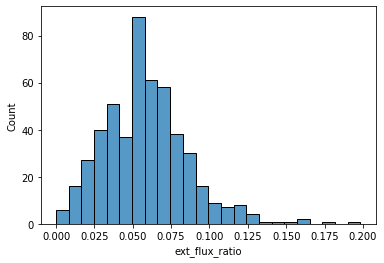

In [39]:
sns.histplot(df_aux_flux['ext_flux_ratio'])

Most stations have around 1 extreme event every 20 days of recorded data. Let's take a look at the stations with most extreme events.

In [40]:
stations_highest_ratio_extflux = df_aux_flux[df_aux_flux['ext_flux_ratio']>0.15]['gauge_name'].to_list()
df_flux_highest = df_flux_complete[df_flux_complete['gauge_name'].isin(stations_highest_ratio_extflux)]
df_flux_highest

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2,...,precip_75,flux_25,temp_max_25,precip_25,cutoff_extreme_values_flux,cutoff_extreme_values_temp,cutoff_extreme_values_precip,flux_extreme,temp_extreme,precip_extreme
564071,1988-08-26,3434003,6.370,0.0,11.648341,Rio Copiapo En Mal Paso Aguas Abajo Canal,-27.5161,-70.2647,3168.139802,10171.930328,...,0.0,0.001,7.721466,0.0,1.5710,19.759317,0.0,1,0,0
564072,1988-08-27,3434003,6.330,0.0,10.074002,Rio Copiapo En Mal Paso Aguas Abajo Canal,-27.5161,-70.2647,3168.139802,10171.930328,...,0.0,0.001,7.721466,0.0,1.5710,19.759317,0.0,1,0,0
564073,1988-08-28,3434003,6.410,0.0,12.562993,Rio Copiapo En Mal Paso Aguas Abajo Canal,-27.5161,-70.2647,3168.139802,10171.930328,...,0.0,0.001,7.721466,0.0,1.5710,19.759317,0.0,1,0,0
564074,1988-08-29,3434003,6.320,0.0,13.699234,Rio Copiapo En Mal Paso Aguas Abajo Canal,-27.5161,-70.2647,3168.139802,10171.930328,...,0.0,0.001,9.063689,0.0,0.7835,21.042628,0.0,1,0,0
564075,1988-08-30,3434003,6.000,0.0,15.182437,Rio Copiapo En Mal Paso Aguas Abajo Canal,-27.5161,-70.2647,3168.139802,10171.930328,...,0.0,0.001,9.063689,0.0,0.7835,21.042628,0.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944217,2020-01-14,7321002,2.383,0.0,22.327702,Rio Maule En Armerillo,-35.7061,-71.1139,2046.959173,5468.959398,...,0.0,1.110,20.658424,0.0,50.8350,30.175146,0.0,0,0,0
1944218,2020-01-15,7321002,3.673,0.0,23.395035,Rio Maule En Armerillo,-35.7061,-71.1139,2046.959173,5468.959398,...,0.0,1.110,20.658424,0.0,50.8350,30.175146,0.0,0,0,0
1944219,2020-01-16,7321002,3.134,0.0,27.799181,Rio Maule En Armerillo,-35.7061,-71.1139,2046.959173,5468.959398,...,0.0,1.110,20.658424,0.0,50.8350,30.175146,0.0,0,0,0
1944220,2020-01-17,7321002,3.031,0.0,27.394990,Rio Maule En Armerillo,-35.7061,-71.1139,2046.959173,5468.959398,...,0.0,1.110,20.658424,0.0,50.8350,30.175146,0.0,0,0,0


In [41]:
# Number of days of data
df_flux_highest[['gauge_name']].value_counts()

gauge_name                                 
Rio Guatulame En El Tome                       12630
Rio Pama En Valle Hermoso                      10097
Rio Maule En Armerillo                          7045
Rio Copiapo En Mal Paso Aguas Abajo Canal       5444
Rio Cipreses En Dasague Laguna La Invernada     5383
dtype: int64

<AxesSubplot:xlabel='gauge_name', ylabel='flux'>

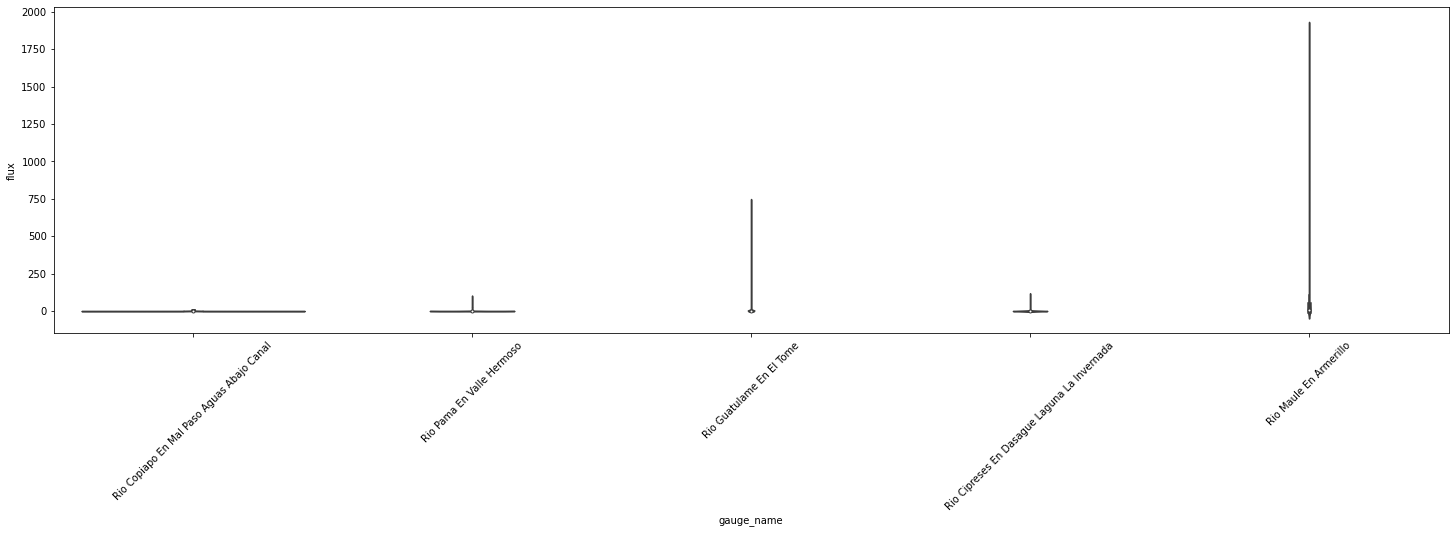

In [42]:
plt.figure(figsize=(25,6))
plt.xticks(rotation=45)
sns.violinplot(x=df_flux_highest["gauge_name"], 
            y=df_flux_highest['flux'], 
            dodge=False)

The order of magnitude of flux for these stations are very different. Let's plot the frequency of the highest 2.

C:\Users\EXMACH~1\AppData\Local\Temp/ipykernel_10540/1947035528.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_flux_highest_2 = df_flux_highest[df_flux_complete['gauge_name'].isin(stations_highest_ratio_extflux_2)]


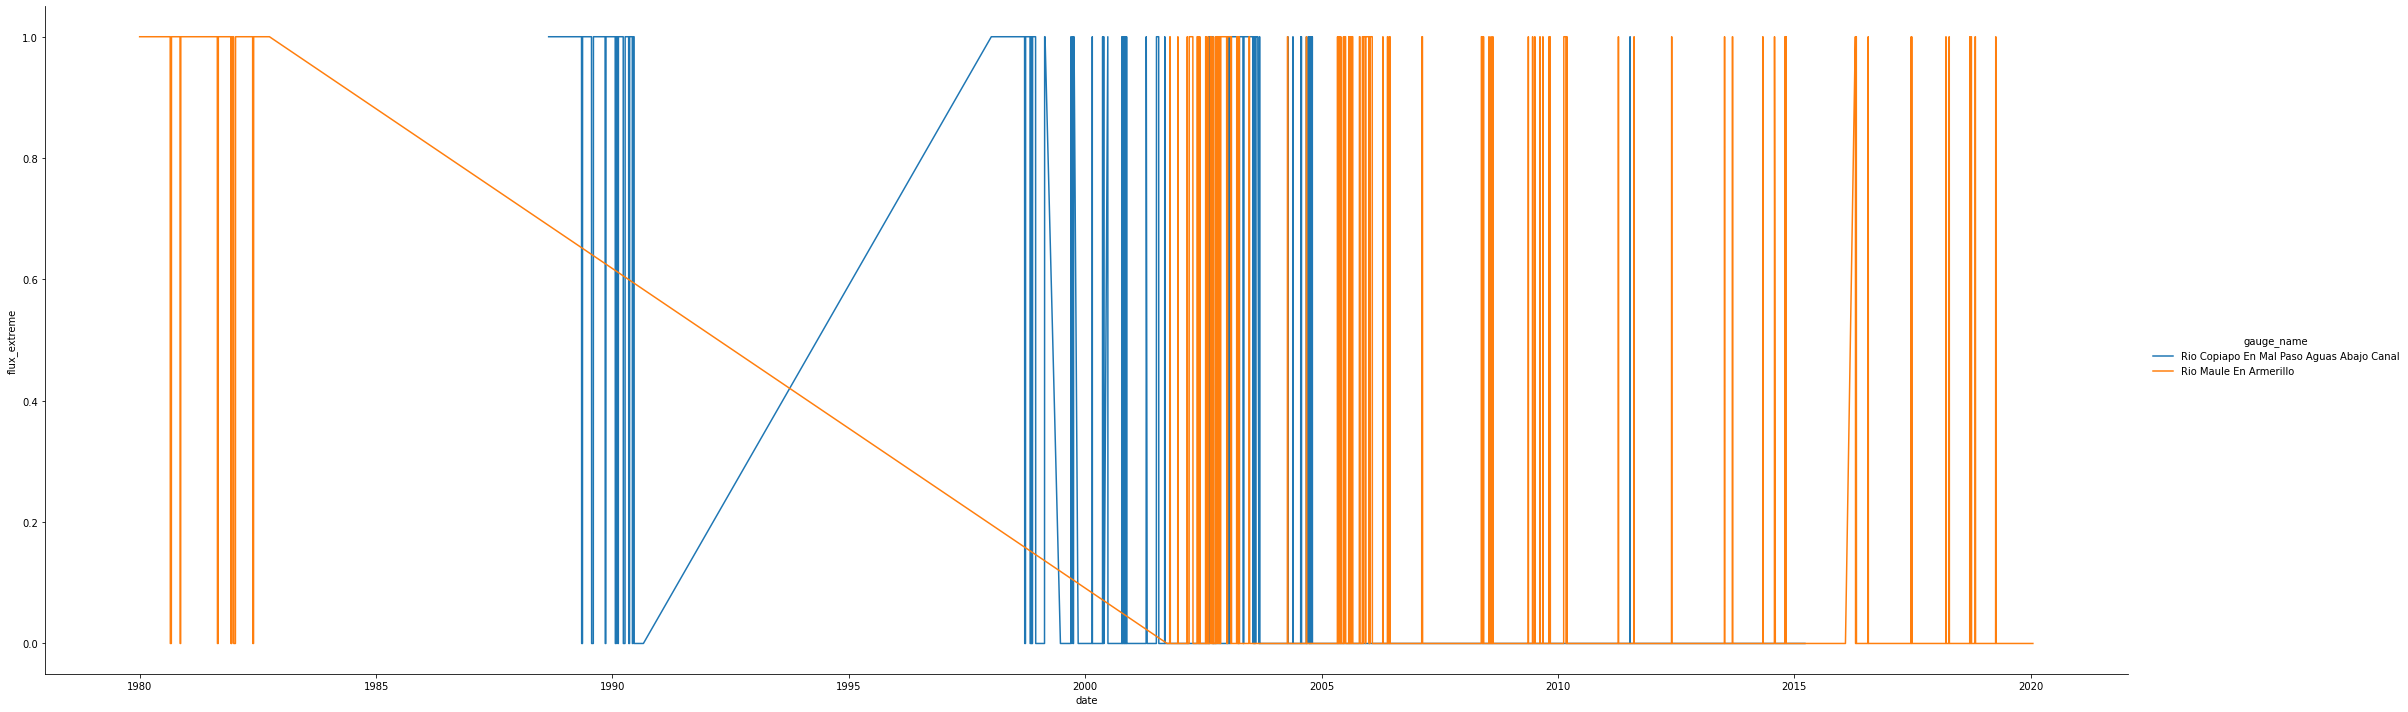

In [43]:
stations_highest_ratio_extflux_2 = df_aux_flux[df_aux_flux['ext_flux_ratio']>0.17]['gauge_name'].to_list()
df_flux_highest_2 = df_flux_highest[df_flux_complete['gauge_name'].isin(stations_highest_ratio_extflux_2)]
sns.relplot(
    data=df_flux_highest_2,
    x="date", 
    y="flux_extreme", 
    hue="gauge_name", 
    kind="line",
    height=10, 
    aspect=3,
)

The extreme events in those 2 stations have ocurred in different periods of time, for example, most recently there have been some extreme flux days for one station but not for the other.

Let's group stations according to the ratio of extreme events and take a look at their extreme events behaviour

In [44]:
# We group the stations according their extreme flux ratio
conditions = [
    (df_aux_flux['ext_flux_ratio']<=0.025),
    (0.025<df_aux_flux['ext_flux_ratio']) & (df_aux_flux['ext_flux_ratio']<=0.075),
    (0.075<df_aux_flux['ext_flux_ratio']) & (df_aux_flux['ext_flux_ratio']<=0.125),
    (0.125<df_aux_flux['ext_flux_ratio']),
    ]
values = ['ext_flux_group_1', 
          'ext_flux_group_2', 
          'ext_flux_group_3',
          'ext_flux_group_4']
df_aux_flux['ext_flux_group'] = np.select(conditions, values)
df_flux_complete = pd.merge(df_flux_complete,
                            df_aux_flux,
                            how='left',
                            left_on=['gauge_name'],
                            right_on=['gauge_name'],
                           )

In [45]:
# The monday of week of the year is added
df_flux_complete['week_year'] = pd.to_datetime(df_flux_complete['date'].dt.year.astype(str) 
                                               + ' ' 
                                               + df_flux_complete['week'].astype(str) 
                                               + ' 1',
                                               format='%G %V %u')
df_flux_complete

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2,...,cutoff_extreme_values_temp,cutoff_extreme_values_precip,flux_extreme,temp_extreme,precip_extreme,count_total,count_ext_flux,ext_flux_ratio,ext_flux_group,week_year
0,1980-01-01,1001001,0.579,0.000000,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,...,13.887074,16.109863,0,0,0,6125,190,0.031020,ext_flux_group_2,1979-12-31
1,1980-01-02,1001001,0.543,0.000000,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,...,13.887074,16.109863,0,0,0,6125,190,0.031020,ext_flux_group_2,1979-12-31
2,1980-01-03,1001001,0.482,0.000000,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,...,13.887074,16.109863,0,0,0,6125,190,0.031020,ext_flux_group_2,1979-12-31
3,1980-01-04,1001001,0.459,0.000000,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,...,13.887074,16.109863,0,0,0,6125,190,0.031020,ext_flux_group_2,1979-12-31
4,1980-01-05,1001001,0.436,0.000000,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,...,13.887074,16.109863,0,0,0,6125,190,0.031020,ext_flux_group_2,1979-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175032,2020-04-25,12930001,0.431,0.000000,4.138484,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,...,13.055306,7.269628,0,0,0,5563,303,0.054467,ext_flux_group_2,2020-04-20
4175033,2020-04-26,12930001,0.362,0.000000,7.685259,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,...,13.055306,7.269628,0,0,0,5563,303,0.054467,ext_flux_group_2,2020-04-20
4175034,2020-04-27,12930001,0.342,0.000000,9.646850,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,...,13.522310,4.757199,0,0,0,5563,303,0.054467,ext_flux_group_2,2020-04-27
4175035,2020-04-28,12930001,0.359,0.000000,8.154713,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,...,13.522310,4.757199,0,0,0,5563,303,0.054467,ext_flux_group_2,2020-04-27


For each extreme flux group and each week, we'll plot the proportion of extreme flux events, the amount of days recorded and the total extreme flux events.

#### Plot 1

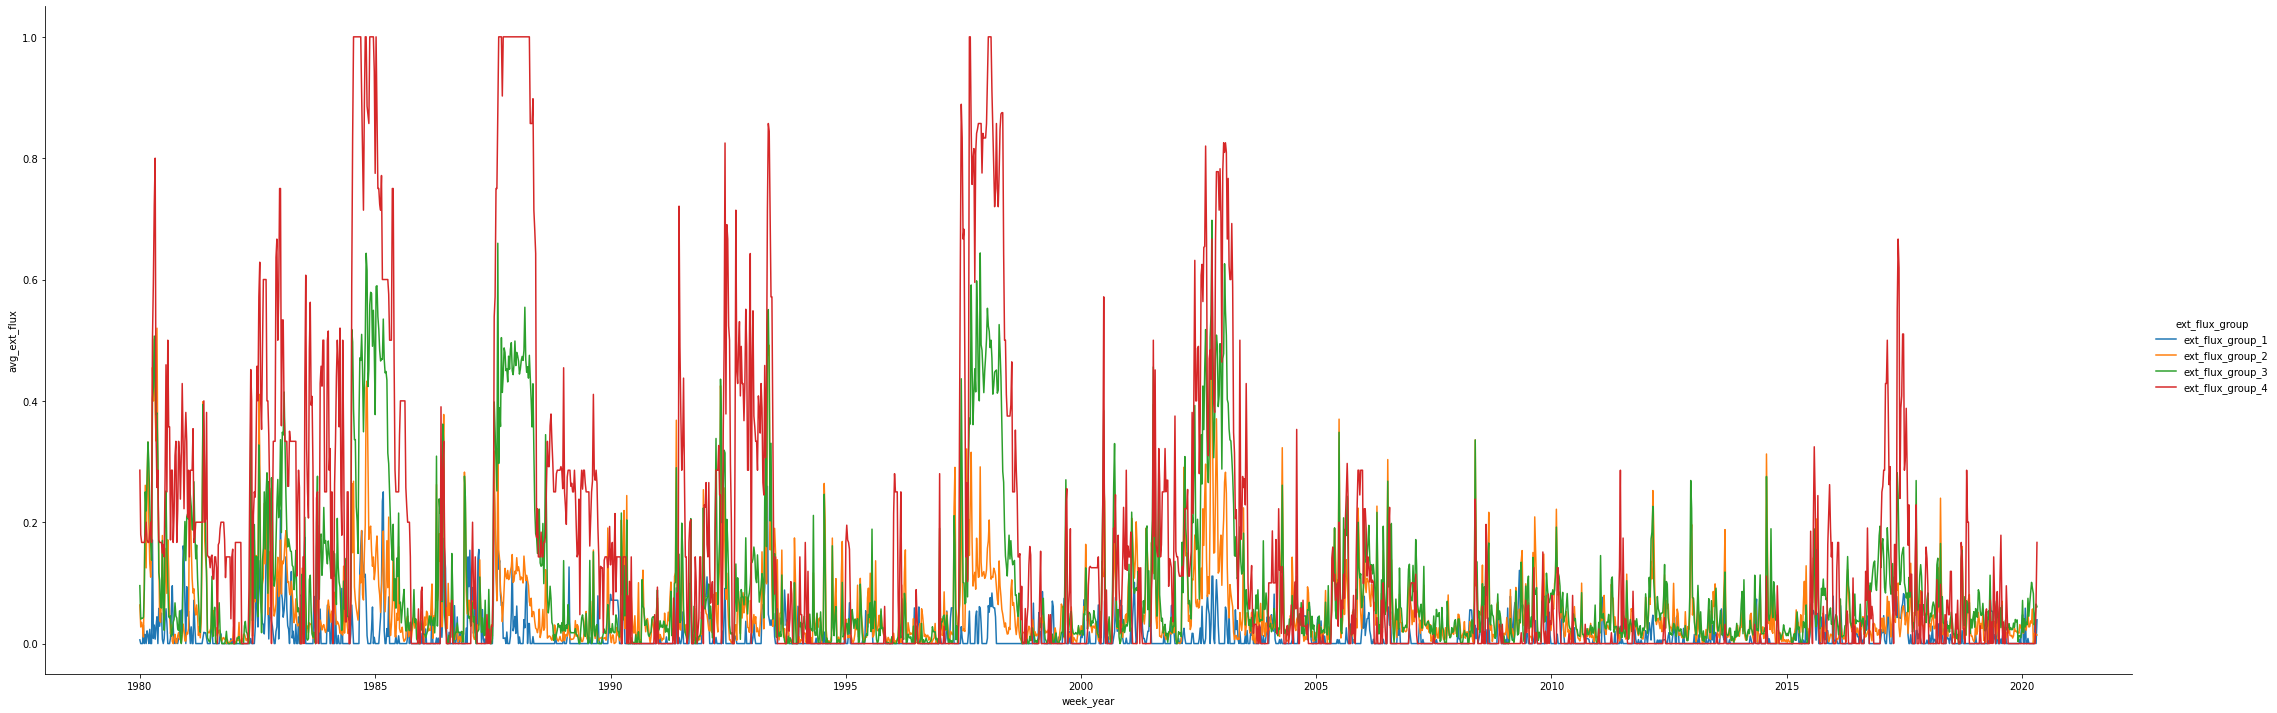

In [46]:
# Group by week and ext. flux group then take the mean of extreme flux
group_cols = ['week_year','ext_flux_group']
df_flux_complete_m = df_flux_complete.groupby(group_cols)[['flux_extreme']].agg(avg_ext_flux=('flux_extreme','mean')).reset_index()
# Plot frequency of extreme flux over time for each ext. flux group
sns.relplot(
    data=df_flux_complete_m,
    x="week_year", 
    y="avg_ext_flux",
    hue="ext_flux_group",
    kind="line",
    height=10, 
    aspect=3,
)

#### Plot 2

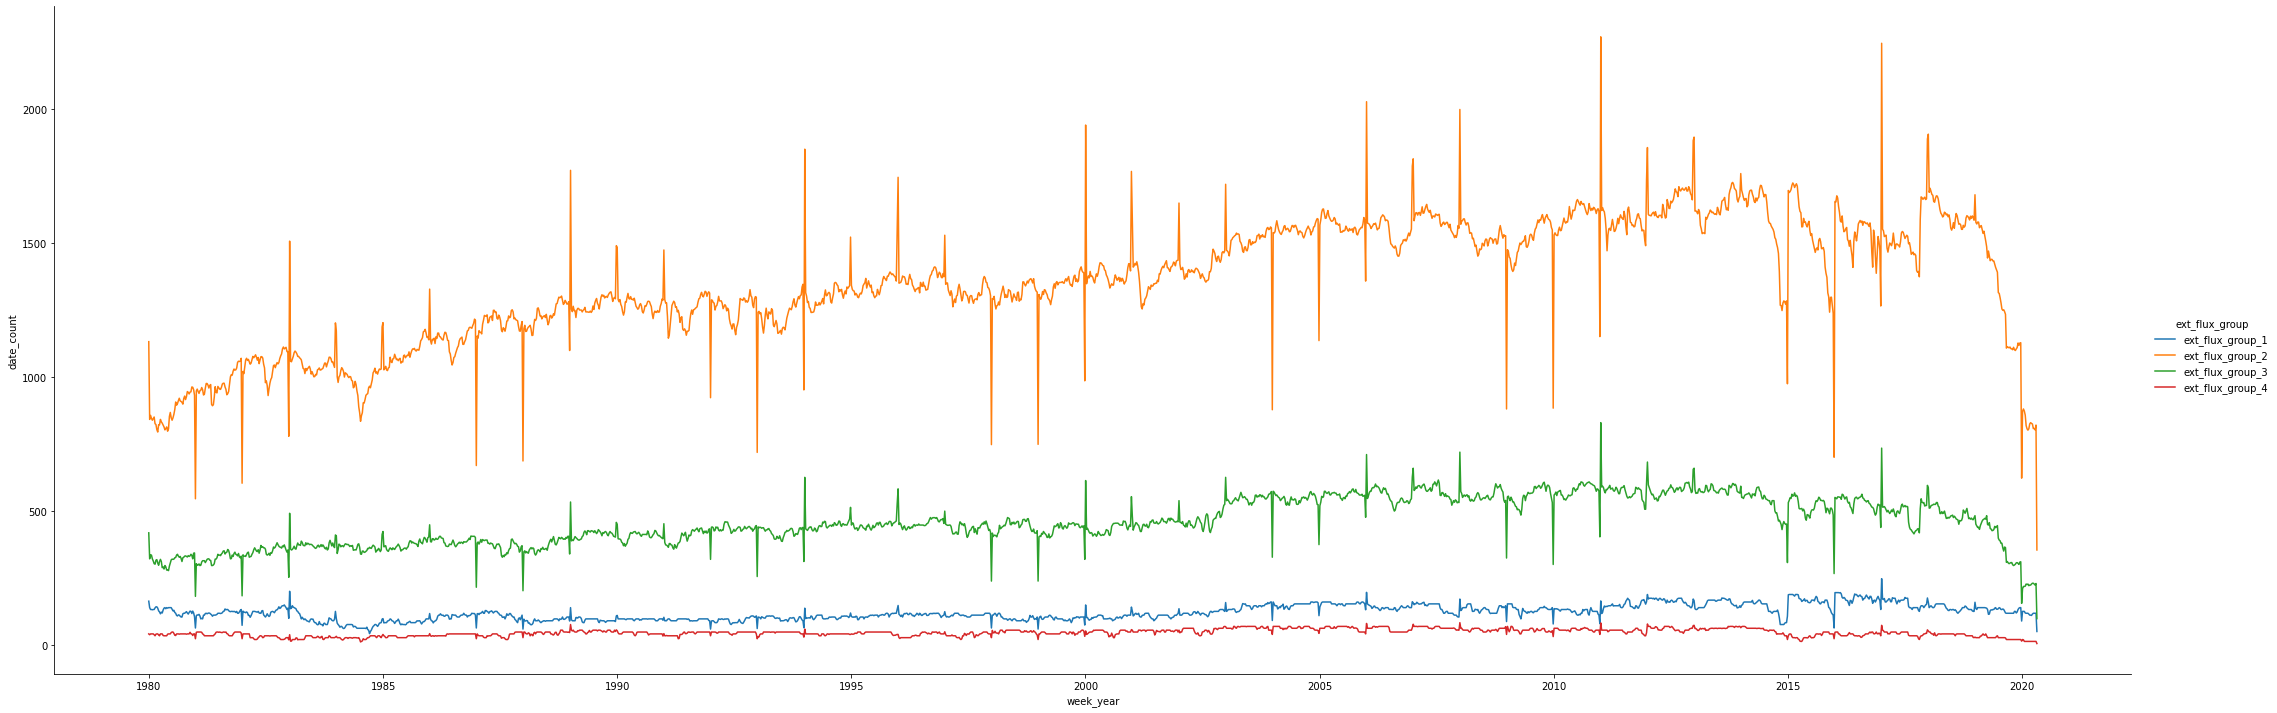

In [47]:
# Group by week and ext. flux group then get the amount of data
group_cols = ['week_year','ext_flux_group']
df_flux_complete_m = df_flux_complete.groupby(group_cols)[['date']].agg(date_count=('date','count')).reset_index()
# Plot amount of data over time for each ext. flux group
sns.relplot(
    data=df_flux_complete_m,
    x="week_year", 
    y="date_count",
    hue="ext_flux_group",
    kind="line",
    height=10, 
    aspect=3,
)

#### Plot 3

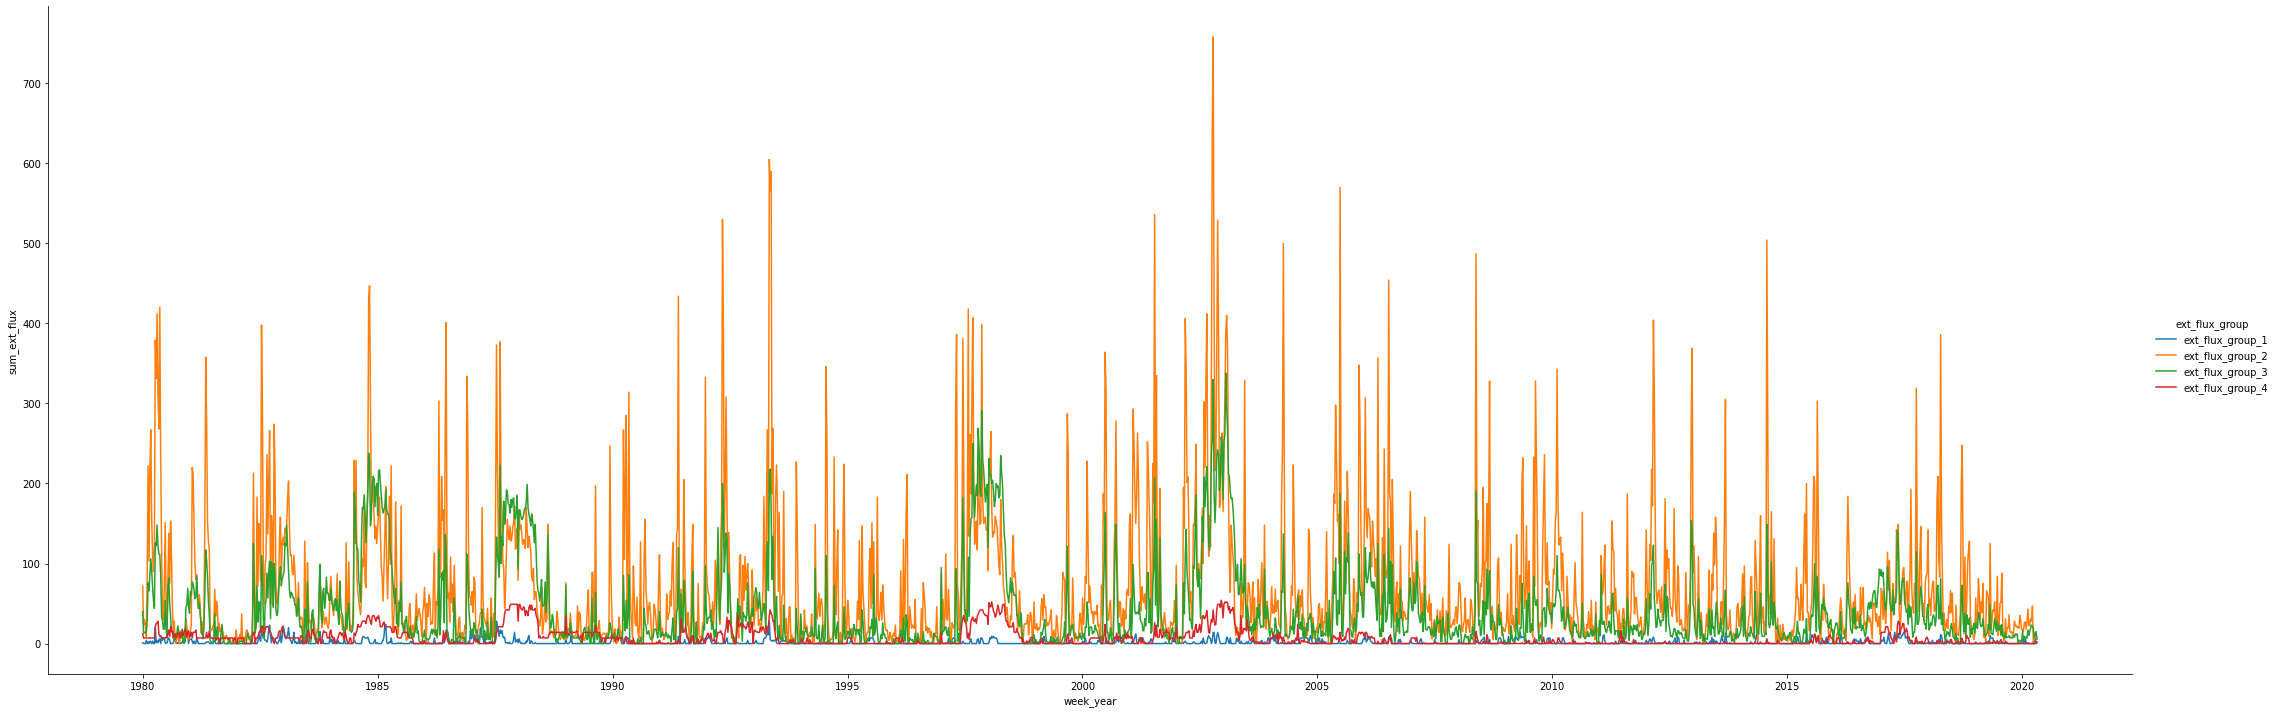

In [48]:
# Group by week and ext. flux group then get the amount of data
group_cols = ['week_year','ext_flux_group']
df_flux_complete_m = df_flux_complete.groupby(group_cols)[['flux_extreme']].agg(sum_ext_flux=('flux_extreme','sum')).reset_index()
# Plot amount of data over time for each ext. flux group
sns.relplot(
    data=df_flux_complete_m,
    x="week_year", 
    y="sum_ext_flux",
    hue="ext_flux_group",
    kind="line",
    height=10, 
    aspect=3,
)

#### Comments

There is a stable amount of data for each extreme flux group (last chart). For each group we find that the amount of extreme events increased in similar dates (chart 1 and 3).

## 6. Percentage of extreme events

Let's look at the general rate of ocurrence of extreme events. We'll take the mean of the variable for every week, which will tell us the proportion of extreme events for each year.

### 6.1 Extreme flux

We saw earlier that the proportion has decreased for all groups we looked at. In general we have:

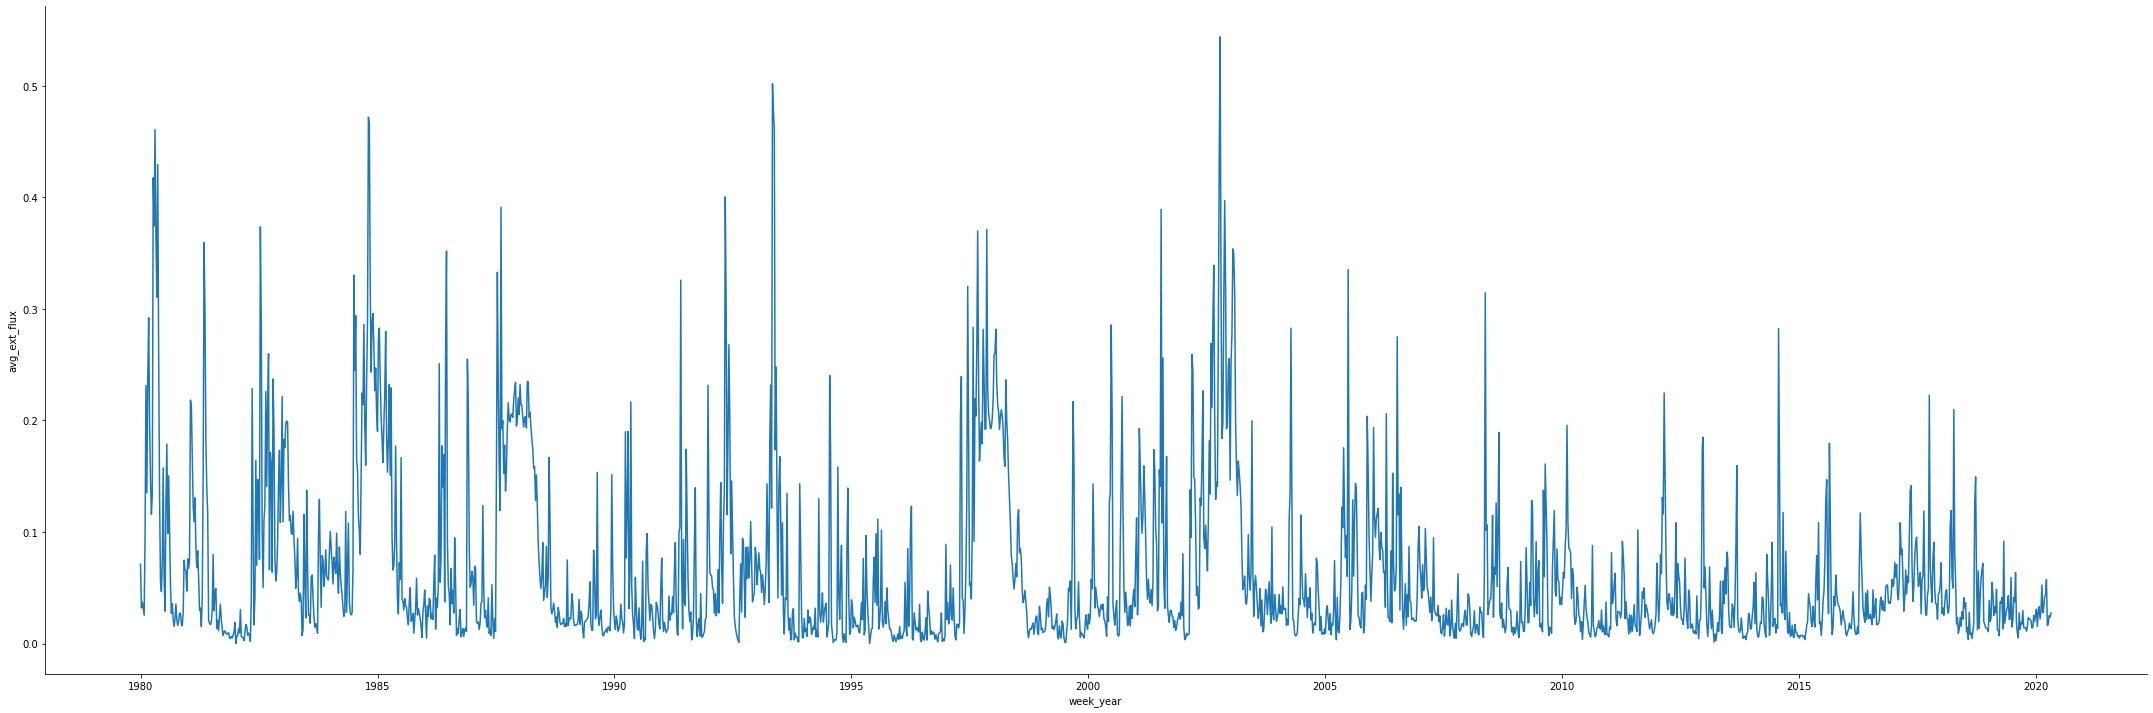

In [49]:
group_cols = ['week_year']
df_flux_complete_m = df_flux_complete.groupby(group_cols)[['flux_extreme']].agg(avg_ext_flux=('flux_extreme','mean')).reset_index()
sns.relplot(
    data=df_flux_complete_m,
    x="week_year", 
    y="avg_ext_flux",
    kind="line",
    height=10, 
    aspect=3,
)

The general proportion of extreme flux days has declined over time.

### 6.2 Temperature

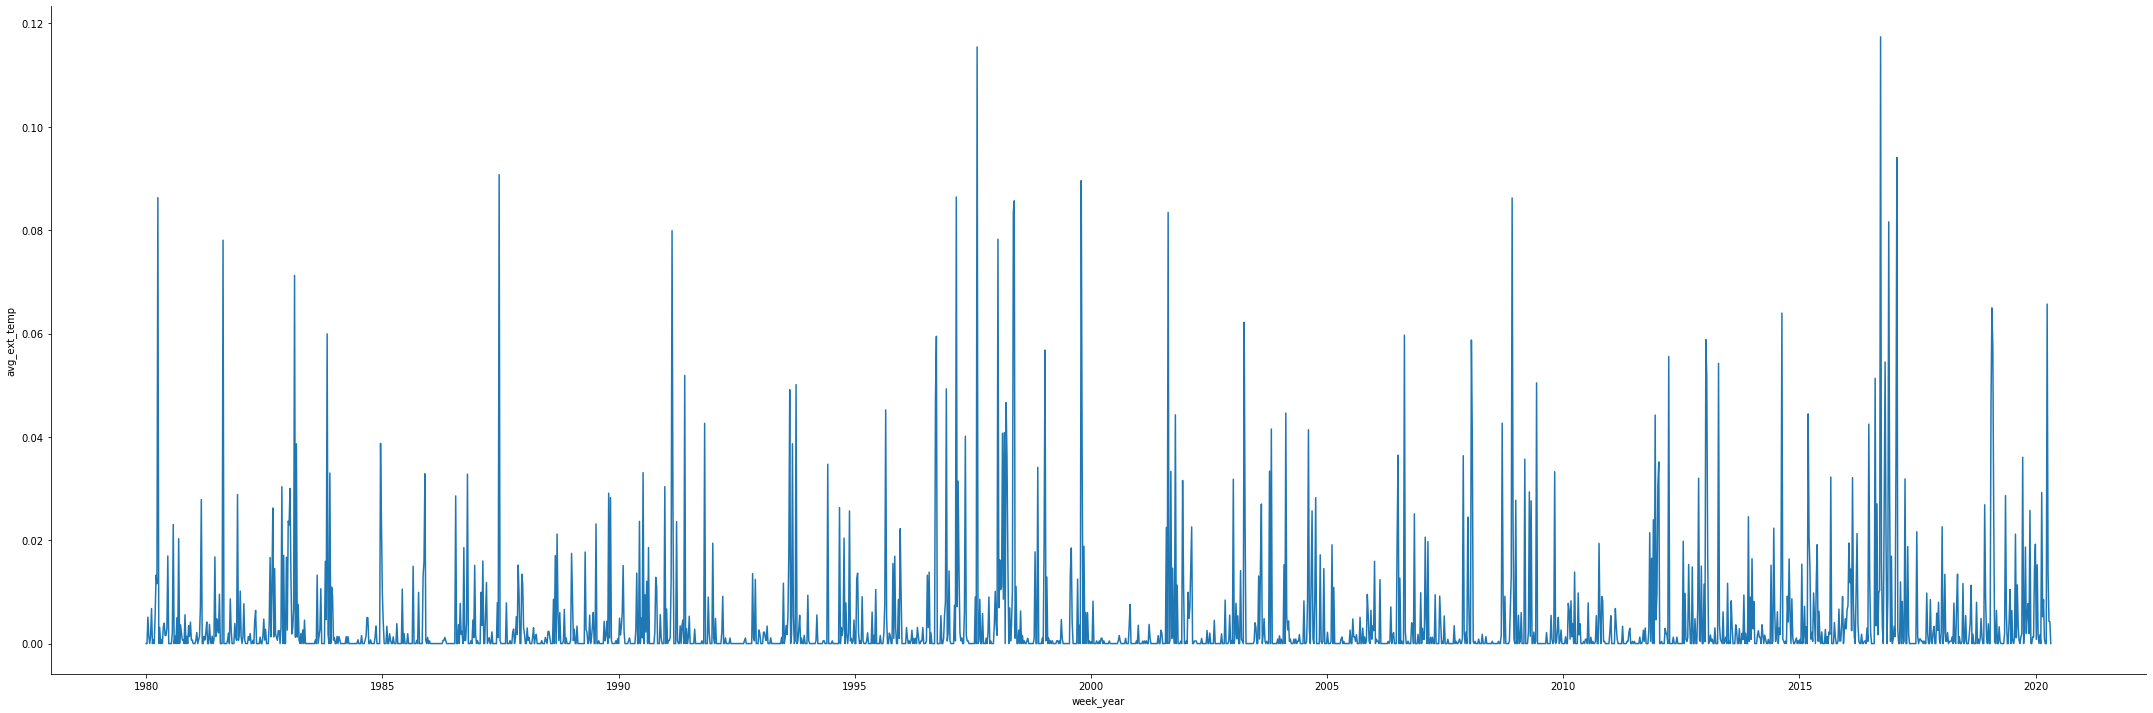

In [50]:
group_cols = ['week_year']
df_flux_complete_m = df_flux_complete.groupby(group_cols)[['temp_extreme']].agg(avg_ext_temp=('temp_extreme','mean')).reset_index()
sns.relplot(
    data=df_flux_complete_m,
    x="week_year", 
    y="avg_ext_temp",
    kind="line",
    height=10, 
    aspect=3,
)

There seems to have been an increase in the proportion of extreme temperatures.

### 6.3 Precipitation

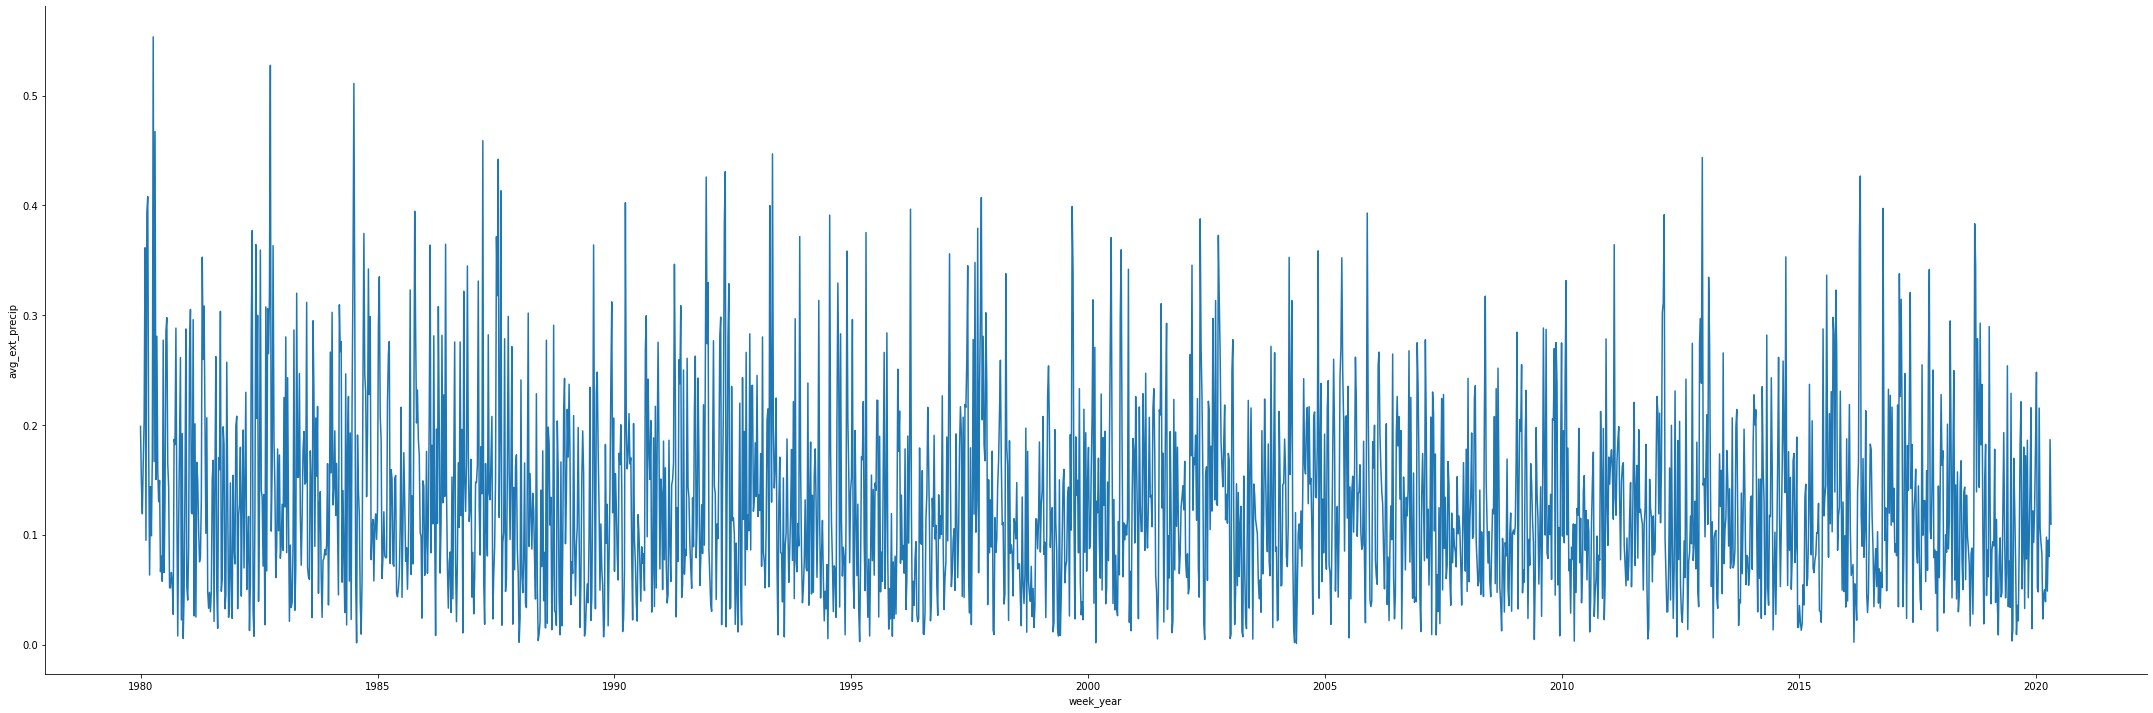

In [51]:
group_cols = ['week_year']
df_flux_complete_m = df_flux_complete.groupby(group_cols)[['precip_extreme']].agg(avg_ext_precip=('precip_extreme','mean')).reset_index()
sns.relplot(
    data=df_flux_complete_m,
    x="week_year", 
    y="avg_ext_precip",
    kind="line",
    height=10, 
    aspect=3,
)

The behaviour of extreme precipitation events over time hasn't changed much.

## 7. Extreme flux prediction


### 7.1 Some discussion

Mostly, the data to be used are of 2 types:
- Fixed watershed features
- Temperature and precipitation of past days

Given that precipitation and temperature data isn't registered in the same station, it's very likely that those values aren't immediately available for the model, i.e. to use it, we should have some integration process that makes that data available to do predictions.

In addition, we could use same day data to train the model and then, when a prediction for day $n+1$ is needed, use a forecast of precipitation or temperature, which is data that can be available the day $n$.

As the instructions suggested, once the model is trained, we could use it to predict a probability for the next day if the model directly predicts probability. Other possibility is to predict the flux, and then classify it as an extreme flux or not. In this case, the probability of that event occurring can be seen as how likely it is according to past data.

A first model to train would be a Logistic Regression model with the following variables:
- Week of the year: This is to control for cyclical variations over the year. Probably grouping by month is good also.
- Geographical location group: This variable aids the model to distinguish behaviour of different locations by latitude.
- Altitude group: Similar to the Geographical location group variable
- Temperature of the previous day: Intuitively this variable should be linked to flux (worth doing a scatterplot)
- Flux of the previous day: Intuitively this variable should be linked to flux (worth doing a scatterplot)
    
In this case, we need the precipitation and flux data of the day $n$ to make a prediction for the $n+1$ day, so that is a must have. Also, for each station that we want to predict, we ought to know that geographical location group and which altitude group does the station belong to (groups used for training). Then, the result of the model is a probability so we can directly report its output.

### 7.2 Model

In [52]:
df_flux_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4175037 entries, 0 to 4175036
Data columns (total 31 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   date                          datetime64[ns]
 1   basin_id                      int64         
 2   flux                          float64       
 3   precip                        float64       
 4   temp_max                      float64       
 5   gauge_name                    object        
 6   lat                           float64       
 7   lon                           float64       
 8   mean_elev                     float64       
 9   area_km2                      float64       
 10  has_nan                       bool          
 11  lat_group                     object        
 12  mean_elev_group               object        
 13  week                          object        
 14  flux_75                       float64       
 15  temp_max_75                   fl

In [53]:
df_aux_add = df_flux_complete[['gauge_name','date','temp_max','flux']]
df_aux_add['date'] = df_aux_add['date'] + pd.Timedelta(days=1)
col_name_changes = {('date'):'next_day', 
                    ('temp_max'):'temp_max_prev_day',
                    ('flux'):'flux_prev_day',
                   }
df_aux_add = df_aux_add.rename(columns=col_name_changes)
df_flux_complete = pd.merge(df_flux_complete,
                            df_aux_add,
                            how='left',
                            left_on=['gauge_name','date'],
                            right_on=['gauge_name','next_day'],
                           )
df_flux_complete

C:\Users\EXMACH~1\AppData\Local\Temp/ipykernel_10540/2488428223.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux_add['date'] = df_aux_add['date'] + pd.Timedelta(days=1)


,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2,...,temp_extreme,precip_extreme,count_total,count_ext_flux,ext_flux_ratio,ext_flux_group,week_year,next_day,temp_max_prev_day,flux_prev_day
0,1980-01-01,1001001,0.579,0.000000,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,...,0,0,6125,190,0.031020,ext_flux_group_2,1979-12-31,NaT,NaN,NaN
1,1980-01-02,1001001,0.543,0.000000,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,...,0,0,6125,190,0.031020,ext_flux_group_2,1979-12-31,1980-01-02,10.685653,0.579
2,1980-01-03,1001001,0.482,0.000000,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,...,0,0,6125,190,0.031020,ext_flux_group_2,1979-12-31,1980-01-03,11.470960,0.543
3,1980-01-04,1001001,0.459,0.000000,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,...,0,0,6125,190,0.031020,ext_flux_group_2,1979-12-31,1980-01-04,11.947457,0.482
4,1980-01-05,1001001,0.436,0.000000,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859,...,0,0,6125,190,0.031020,ext_flux_group_2,1979-12-31,1980-01-05,12.424489,0.459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175032,2020-04-25,12930001,0.431,0.000000,4.138484,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,...,0,0,5563,303,0.054467,ext_flux_group_2,2020-04-20,2020-04-25,4.243332,0.425
4175033,2020-04-26,12930001,0.362,0.000000,7.685259,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,...,0,0,5563,303,0.054467,ext_flux_group_2,2020-04-20,2020-04-26,4.138484,0.431
4175034,2020-04-27,12930001,0.342,0.000000,9.646850,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,...,0,0,5563,303,0.054467,ext_flux_group_2,2020-04-27,2020-04-27,7.685259,0.362
4175035,2020-04-28,12930001,0.359,0.000000,8.154713,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617,...,0,0,5563,303,0.054467,ext_flux_group_2,2020-04-27,2020-04-28,9.646850,0.342


In [54]:
df_flux_complete_t = df_flux_complete
df_flux_complete_t['week'] = df_flux_complete_t['week'].astype(str)
# Relevant columns
feature_cols = [
               'week',
               'lat_group',
               'mean_elev_group',
               'temp_max_prev_day',
               'flux_prev_day',
                ]
response_col = ['flux_extreme']
relevant_cols = feature_cols + response_col
# Separate train and test
X = df_flux_complete_t[feature_cols]
y = df_flux_complete_t[response_col]
X_train, X_test, y_train, y_test = train_test_split(X,
                                     y,
                                     test_size = 0.2,
                                     random_state=85, 
                                     stratify=df_flux_complete_t[
                                                                ['lat_group', 
                                                                 'mean_elev_group',
                                                                 'week',
                                                                 ]
                                                                ]
                                     )
df_train = pd.concat([X_train, y_train],axis=1, ignore_index=True, sort=False)
df_train.columns = X_train.columns.to_list()+y_train.columns.to_list()
all_columns = "+".join(df_train.columns.difference(['flux_extreme']))
model_1 = smf.logit(formula='flux_extreme ~ '+all_columns, data=df_train)
res_1 = model_1.fit()
print(res_1.summary())

Optimization terminated successfully.
         Current function value: 0.225954
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           flux_extreme   No. Observations:              3327953
Model:                          Logit   Df Residuals:                  3327894
Method:                           MLE   Df Model:                           58
Date:                Mon, 04 Jul 2022   Pseudo R-squ.:                 0.02102
Time:                        21:37:52   Log-Likelihood:            -7.5196e+05
converged:                       True   LL-Null:                   -7.6811e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -2.5319      0.0

Work to be done:
- Check model's error with test
- Check model's summary to understand relevant variables and explained variance: 
   - Possible more useful to use months over weeks. 
   - Model does not explain much variance.
- Check the model's hypothesis
- Transform variables: As we saw in the EDA, maybe using logs is a good idea.
- Explore other models